In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from scipy.stats import pearsonr
from scipy import stats

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
pd.DataFrame
import optuna

from matplotlib.colors import LinearSegmentedColormap

import statsmodels.api as sm

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
np.set_printoptions(linewidth=100)
#torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 100)

In [4]:
base_path = '/home/sam/Desktop/logs_server/computed_numpy/convnextv2_atto.fcmae_2024_02_07-19_30_14.pt'

In [5]:
""" for reference
teacher_mean_flat = np.load(os.path.join(base_path, 'teacher_mean_flat.npy'))
teacher_var_flat = np.load(os.path.join(base_path, 'teacher_var_flat.npy'))
teacher_loss_flat = np.load(os.path.join(base_path, 'teacher_loss_flat.npy'))
actual_label_flat = np.load(os.path.join(base_path,  'actual_label_flat.npy'))
uncertainties_flat = np.load(os.path.join(base_path, 'uncertainties_flat.npy'))
spread_flat = np.load(os.path.join(base_path, 'euclidean_spread_flat.npy'))
"""

" for reference\nteacher_mean_flat = np.load(os.path.join(base_path, 'teacher_mean_flat.npy'))\nteacher_var_flat = np.load(os.path.join(base_path, 'teacher_var_flat.npy'))\nteacher_loss_flat = np.load(os.path.join(base_path, 'teacher_loss_flat.npy'))\nactual_label_flat = np.load(os.path.join(base_path,  'actual_label_flat.npy'))\nuncertainties_flat = np.load(os.path.join(base_path, 'uncertainties_flat.npy'))\nspread_flat = np.load(os.path.join(base_path, 'euclidean_spread_flat.npy'))\n"

In [6]:
pred = np.load(os.path.join(base_path, 'pred.npy'))
loss = np.load(os.path.join(base_path, 'loss.npy'))
label = np.load(os.path.join(base_path,  'label.npy'))
calc_var = np.load(os.path.join(base_path, 'calc_var.npy'))
pred_var = np.load(os.path.join(base_path, 'pred_var.npy'))
spread = np.load(os.path.join(base_path, 'features_l2.npy'))

In [7]:
calc_fano = calc_var / pred
calc_CV = np.sqrt(calc_var) / pred
calc_SNR = pred ** 2 / calc_var

pred_fano = calc_var / pred
pred_CV = np.sqrt(calc_var) / pred
pred_SNR = pred**2/pred_var

spread = spread

In [8]:
print(type(spread))

<class 'numpy.ndarray'>


In [9]:
data = {
    'Pred': pred,
    'Loss': loss,
    'Label': label,
    'Calc_var': calc_var,
    'Calc_fano': calc_fano,
    'Calc_CV': calc_CV,
    'Calc_SNR': calc_SNR,
    'Pred_var': pred_var,
    'Pred_fano': pred_fano,
    'Pred_CV': pred_CV,
    'Pred_SNR': pred_SNR,
    'Spread': spread
}

In [10]:
df = pd.DataFrame(data)
df.head()

Pred         Loss  Label     Calc_var  Calc_fano   Calc_CV   Calc_SNR    Pred_var  \
0  181.829483  8495.404297  274.0  1865.001709  10.256872  0.237506  17.727577   83.182381   
1  558.207031  1698.019409  517.0  6611.571289  11.844300  0.145666  47.128750  170.401230   
2   17.201385   295.887665    0.0    39.730980   2.309755  0.366439   7.447278   19.638834   
3   19.104420   364.978851    0.0    55.569286   2.908714  0.390197   6.567996   22.257839   
4   21.016829   100.336853   11.0    52.810596   2.512777  0.345775   8.363986   23.688705   

   Pred_fano   Pred_CV     Pred_SNR    Spread  
0  10.256872  0.237506   397.463509  0.198616  
1  11.844300  0.145666  1828.596484  0.230099  
2   2.309755  0.366439    15.066458  0.313774  
3   2.908714  0.390197    16.397767  0.327874  
4   2.512777  0.345775    18.646316  0.246729

In [11]:
df.isna().sum().sum()

0

In [12]:
df.describe()

Pred          Loss          Label       Calc_var      Calc_fano        Calc_CV  \
count  119794.000000  1.197940e+05  119794.000000  119794.000000  119794.000000  119794.000000   
mean     1155.727366  1.767219e+05    1074.556447   15110.397277       8.174057       0.228481   
std      2803.413793  1.227928e+06    2715.146382   32873.176775       5.096917       0.109690   
min        15.417596  5.364418e-07       0.000000      18.874678       1.094754       0.010667   
25%        32.815140  6.309556e+02       0.000000     115.975405       3.548549       0.122390   
50%        91.027218  2.352804e+03      66.000000     593.395966       6.558033       0.261100   
75%       902.719559  3.622920e+04     794.000000   12117.781982      12.592520       0.319815   
max     50269.328125  1.544958e+08   53119.000000  821555.125000     138.943873       0.597435   

            Calc_SNR       Pred_var      Pred_fano        Pred_CV      Pred_SNR         Spread  
count  119794.000000  119794.000000  119794.000000  119794.000000  1.197940e+05  119794.000000  
mean       98.177528     324.394684       8.174057       0.228481  6.077663e+03       0.363074  
std       294.582103     547.712970       5.096917       0.109690  3.486457e+04       0.453564  
min         2.801677      17.250830       1.094754       0.010667  6.495011e+00       0.087825  
25%         9.776930      32.675789       3.548549       0.122390  3.360797e+01       0.208094  
50%        14.668474      77.505886       6.558033       0.261100  1.119762e+02       0.246288  
75%        66.759232     355.628876      12.592520       0.319815  2.191220e+03       0.302667  
max      8788.117548    6417.690918     138.943873       0.597435  2.401147e+06      12.355100

In [13]:
bins = 80

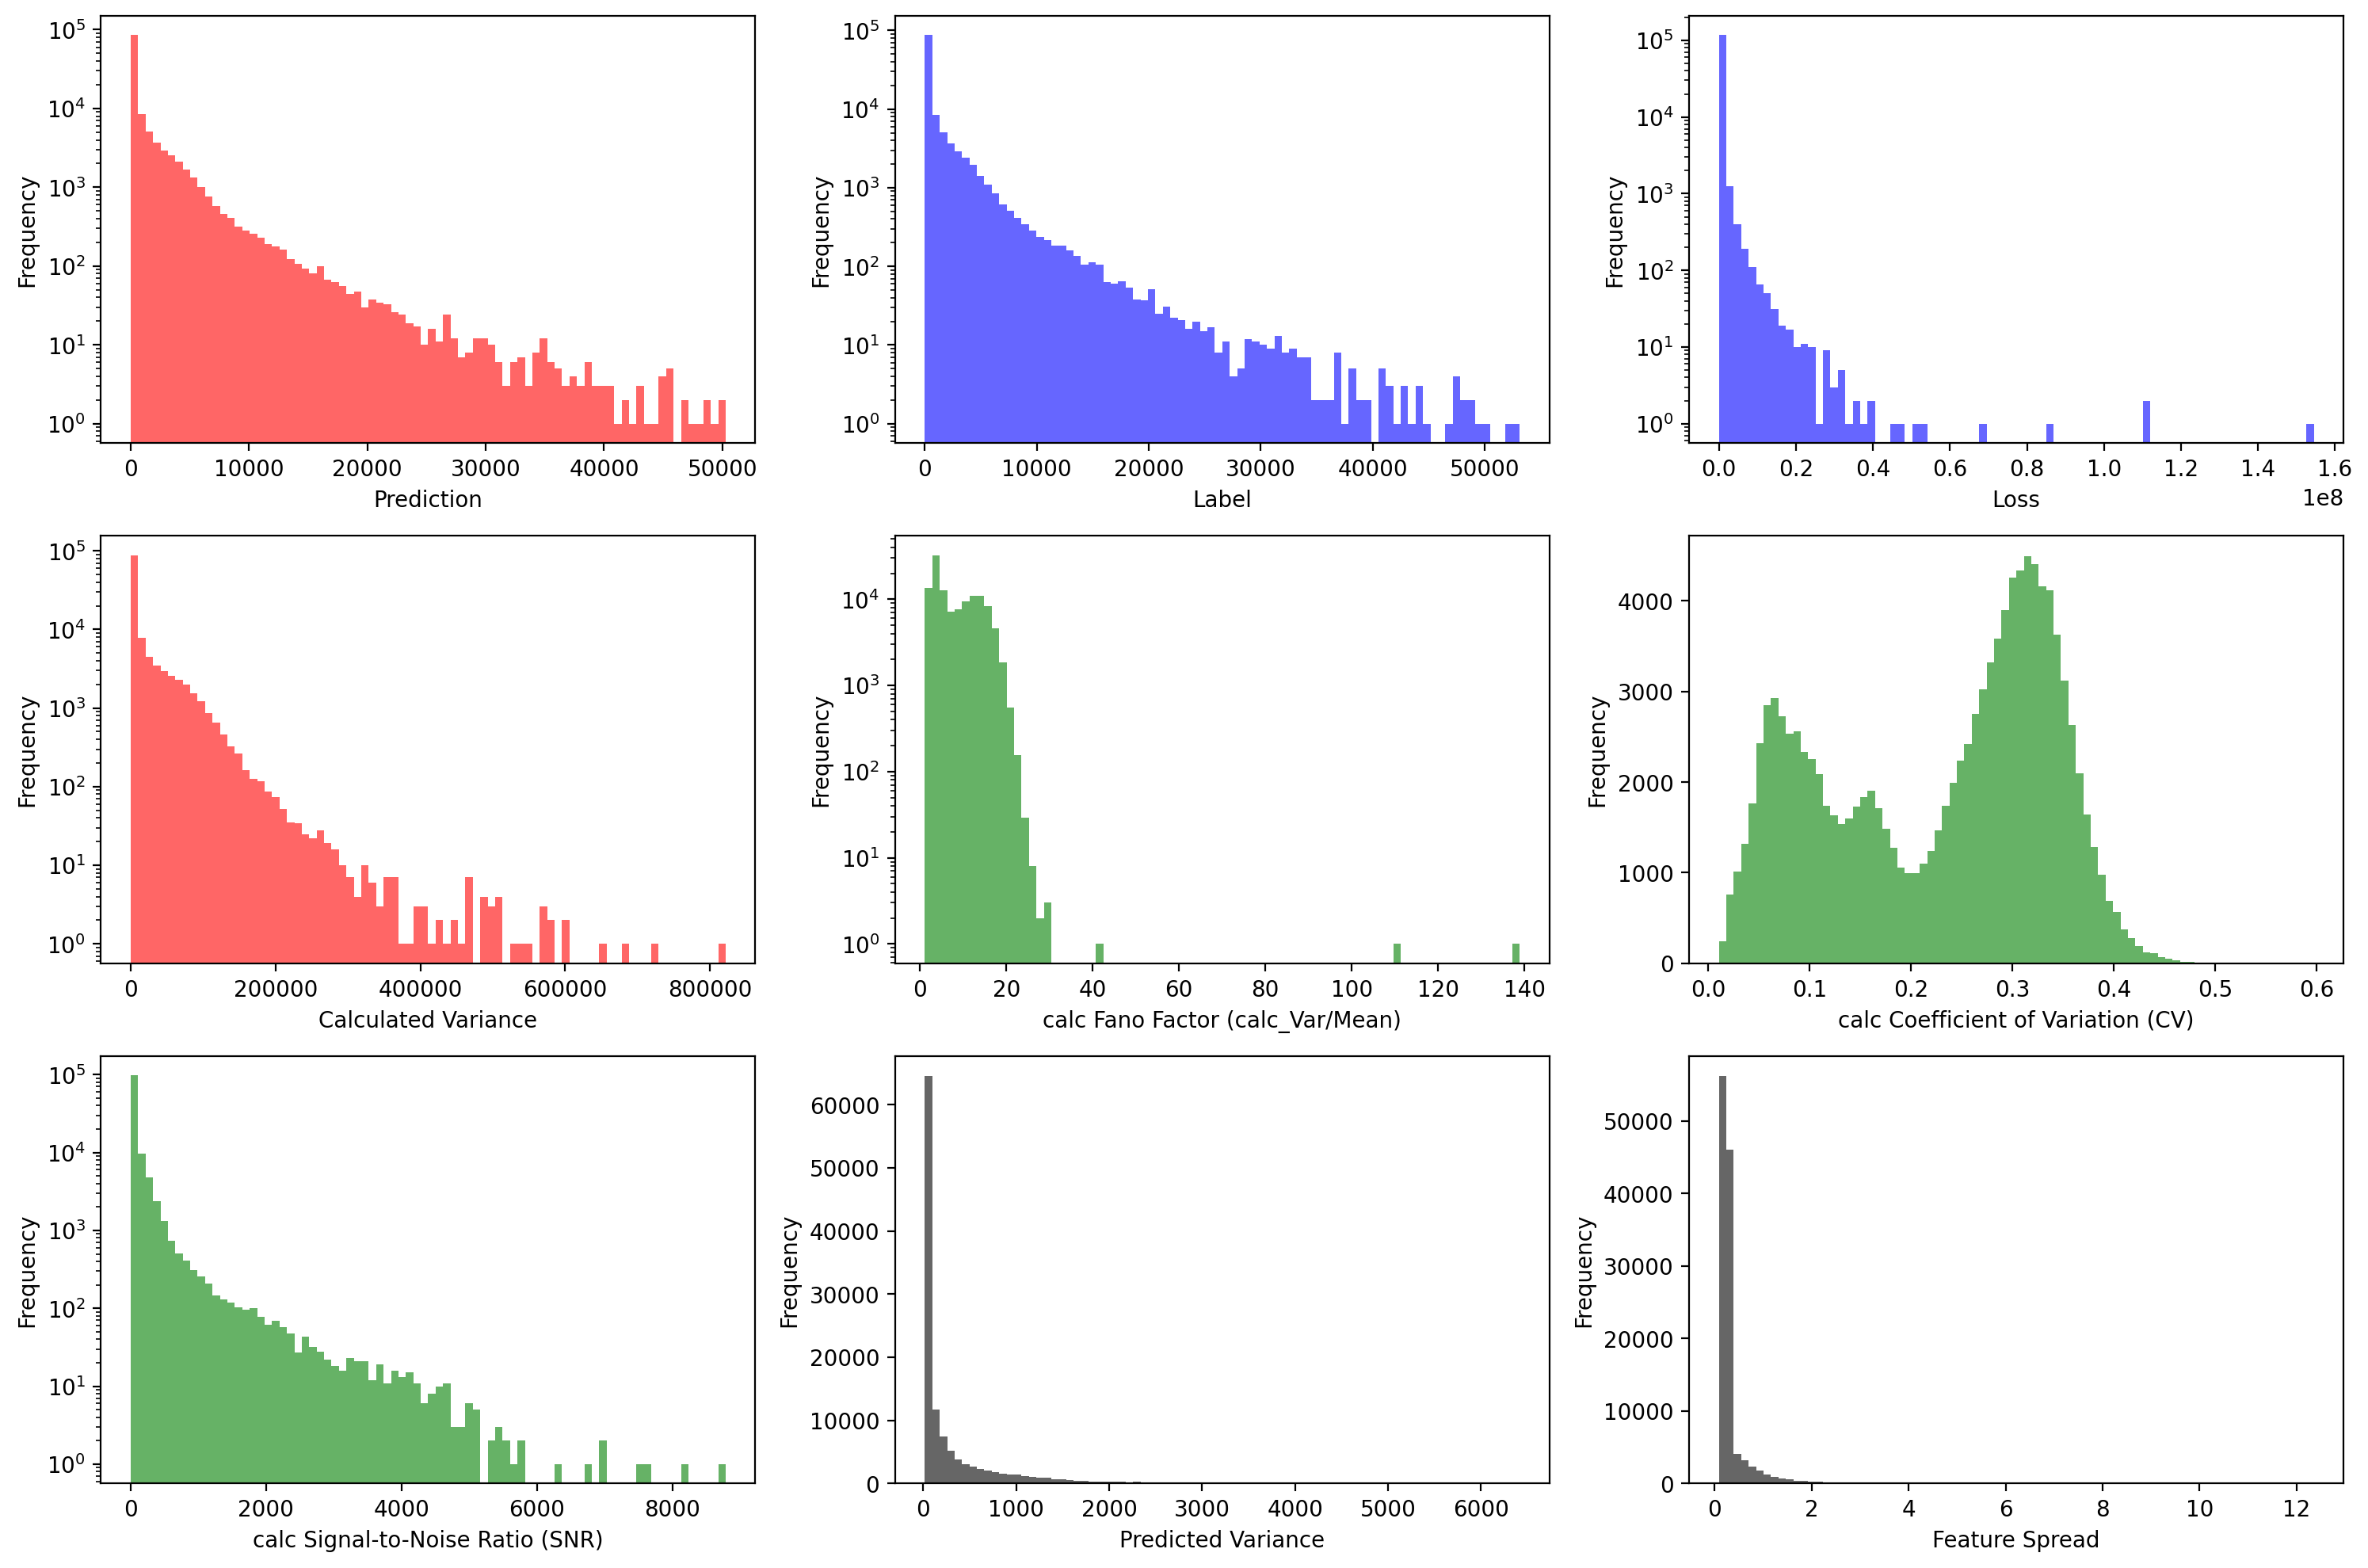

In [14]:
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 3, 1)
ax1.hist(pred, bins=bins, color='red', alpha=0.6)
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Frequency")
# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1 = plt.subplot(3, 3, 2)
ax1.hist(label, bins=bins, color='blue', alpha=0.6)
ax1.set_xlabel("Label")
ax1.set_ylabel("Frequency")
# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1 = plt.subplot(3, 3, 3)
ax1.hist(loss, bins=bins, color='blue', alpha=0.6)
ax1.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
# ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = plt.subplot(3, 3, 4)
ax2.hist(calc_var, bins=bins, color='red', alpha=0.6)
ax2.set_xlabel("Calculated Variance")
ax2.set_ylabel("Frequency")
# ax2.set_xscale('log')
ax2.set_yscale('log')

ax4 = plt.subplot(3, 3, 5)
ax4.hist(calc_fano, bins=bins, color='green', alpha=0.6)
ax4.set_xlabel("calc Fano Factor (calc_Var/Mean)")
ax4.set_ylabel("Frequency")
# ax4.set_xscale('log')
ax4.set_yscale('log')

ax5 = plt.subplot(3, 3, 6)
ax5.hist(calc_CV, bins=bins, color='green', alpha=0.6)
ax5.set_xlabel("calc Coefficient of Variation (CV)")
ax5.set_ylabel("Frequency")
# ax5.set_xscale('log')
# ax5.set_yscale('log')

ax6 = plt.subplot(3, 3, 7)
ax6.hist(calc_SNR, bins=bins, color='green', alpha=0.6)
ax6.set_xlabel("calc Signal-to-Noise Ratio (SNR)")
ax6.set_ylabel("Frequency")
# ax6.set_xscale('log')
ax6.set_yscale('log')

ax3 = plt.subplot(3, 3, 8)
ax3.hist(pred_var, bins=bins, color='black', alpha=0.6)
ax3.set_xlabel("Predicted Variance")
ax3.set_ylabel("Frequency")
# ax3.set_xscale('log')
# ax3.set_yscale('log')

ax3 = plt.subplot(3, 3, 9)
ax3.hist(spread, bins=bins, color='black', alpha=0.6)
ax3.set_xlabel("Feature Spread")
ax3.set_ylabel("Frequency")
# ax3.set_xscale('log')
# ax3.set_yscale('log')

plt.tight_layout()

In [15]:
"""
plt.figure(figsize=(10, 7))
plt.hist(spread, bins=bins, color='blue', alpha=0.6)
#ax1.set_title("Label")
plt.xlabel("Feature Spread", fontsize=24)
plt.ylabel("Frequency", fontsize=24)
#plt.xscale('log')
#plt.yscale('log')
#plt.savefig('/home/sam/Desktop/Master_Thesis/HistFeatureSpread.png', format='png', dpi=200)
"""

'\nplt.figure(figsize=(10, 7))\nplt.hist(spread, bins=bins, color=\'blue\', alpha=0.6)\n#ax1.set_title("Label")\nplt.xlabel("Feature Spread", fontsize=24)\nplt.ylabel("Frequency", fontsize=24)\n#plt.xscale(\'log\')\n#plt.yscale(\'log\')\n#plt.savefig(\'/home/sam/Desktop/Master_Thesis/HistFeatureSpread.png\', format=\'png\', dpi=200)\n'

In [16]:
print(f"Pred:            {df['Pred'].skew()}")
print(f"Label:           {df['Label'].skew()}")
print(f"TeacherLoss:     {df['Loss'].skew()}")
print(f"calc_var:        {df['Calc_var'].skew()}")
print(f"pred_var:        {df['Pred_var'].skew()}")
print(f"Spread:          {df['Spread'].skew()}")

Pred:            5.5749426384119865
Label:           5.704708654555032
TeacherLoss:     43.17282581374706
calc_var:        4.2472788798733845
pred_var:        3.164473211116889
Spread:          6.869818228849366


In [17]:
print(f"Pred:            {df['Pred'].kurt()}")
print(f"Label:           {df['Label'].kurt()}")
print(f"TeacherLoss:     {df['Loss'].kurt()}")
print(f"calc_var:        {df['Calc_var'].kurt()}")
print(f"pred_var:        {df['Pred_var'].kurt()}")
print(f"Spread:          {df['Spread'].kurt()}")

Pred:            48.28597646228782
Label:           51.13489828434636
TeacherLoss:     3705.423823431366
calc_var:        34.94656359192901
pred_var:        13.410182480530786
Spread:          71.42002923924095


In [18]:
target = df['Loss']
target_transformed = np.log1p(target)

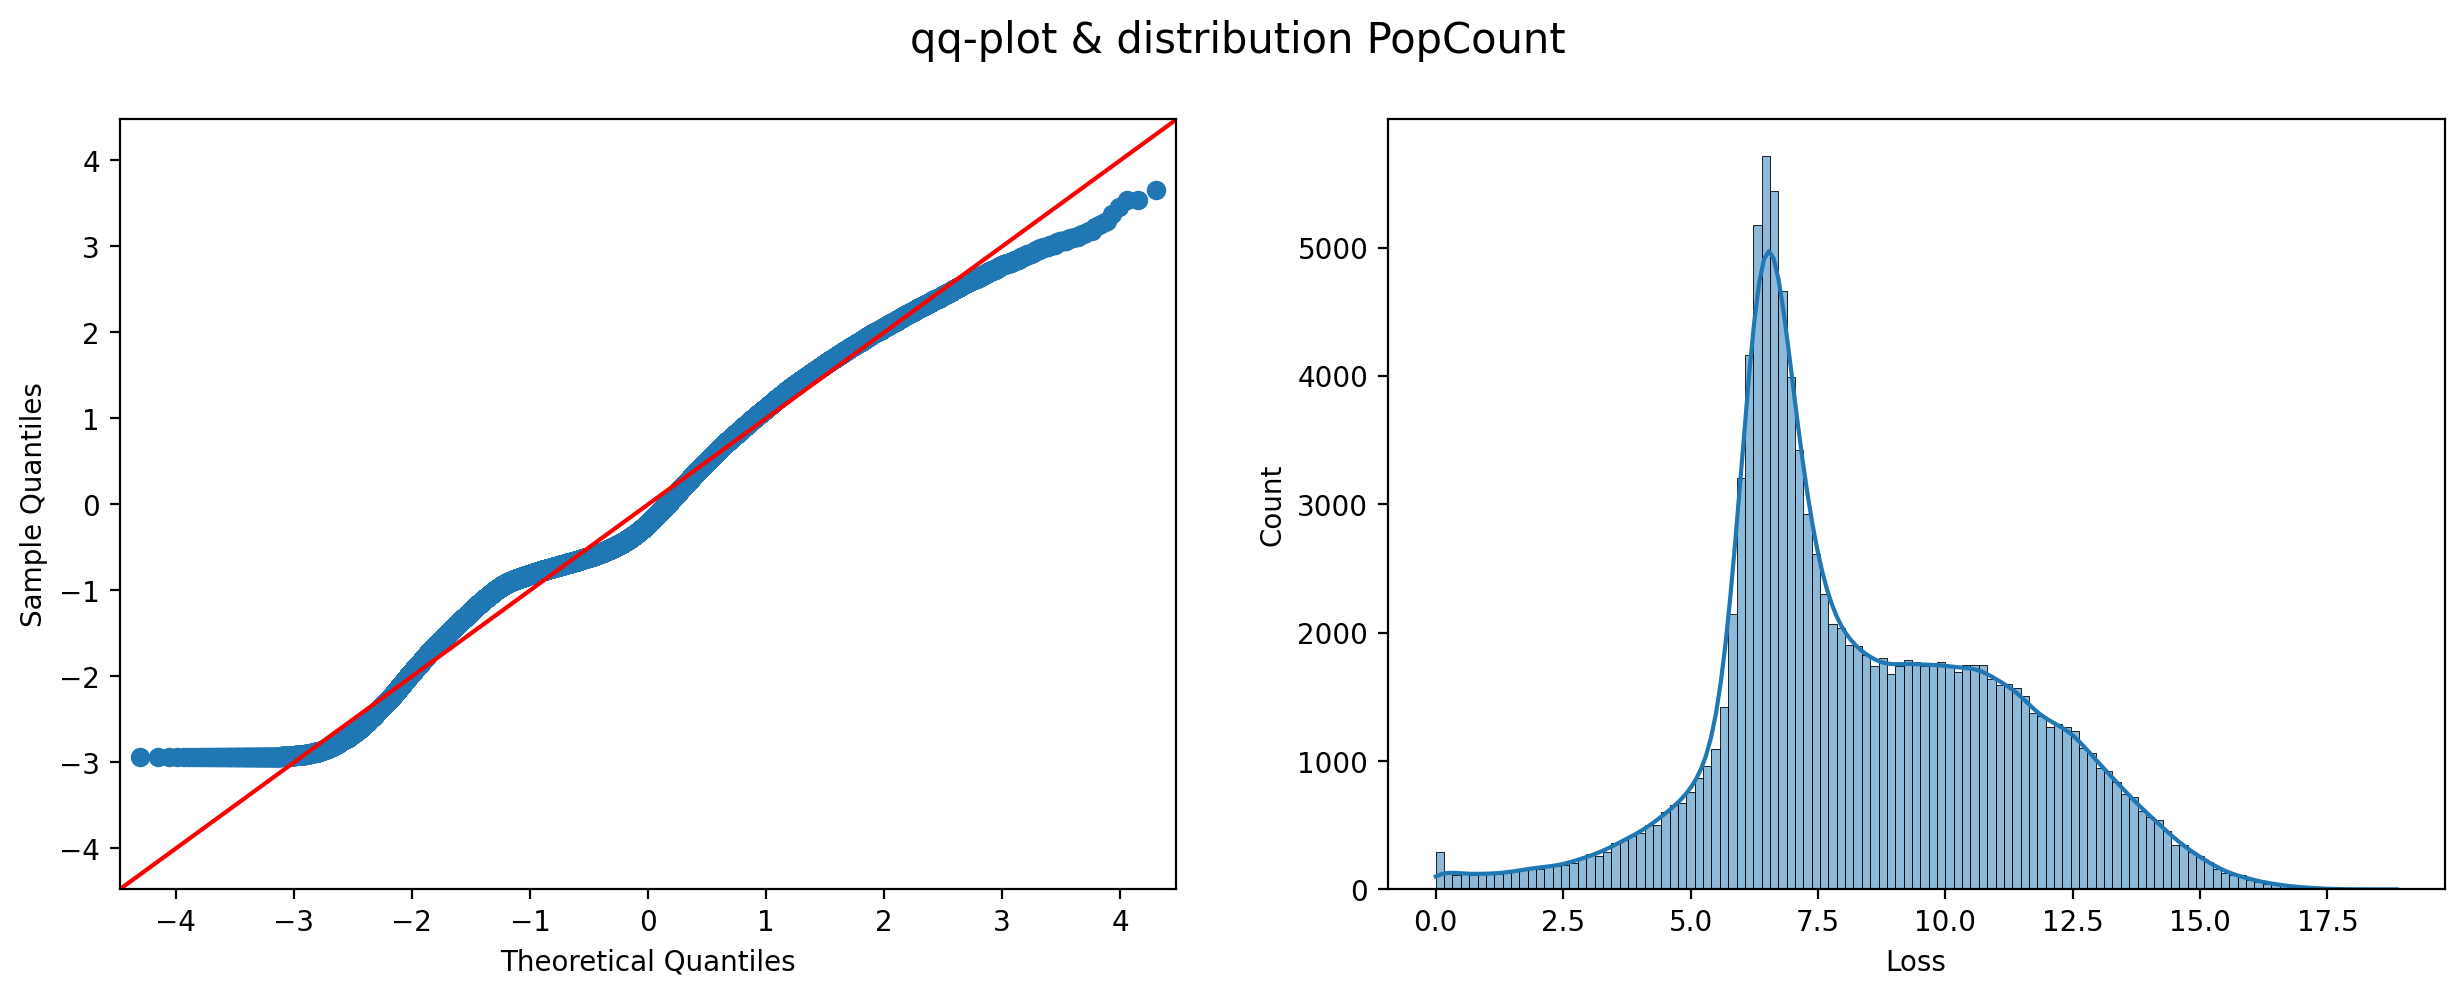

In [19]:
fig, ax = plt.subplots(1, 2, figsize= (15, 5))
fig.suptitle("qq-plot & distribution PopCount ", fontsize=15)

sm.qqplot(target_transformed, stats.t, distargs=(4,),fit=True, line="45", ax=ax[0])
sns.histplot(target_transformed, kde=True, ax=ax[1])
plt.show()

In [20]:
label_log1p = np.log1p(label)
loss = loss
loss2 = np.log(loss) / pred
loss3 = np.sqrt(loss) / (pred+1)
loss4 = loss / (pred+1)

In [21]:
data ['Loss2'] = loss2
data ['Loss3'] = loss3
data ['Loss4'] = loss4

In [22]:
df = pd.DataFrame(data)
#df.head()

In [23]:
corr_matrix = df.corr()

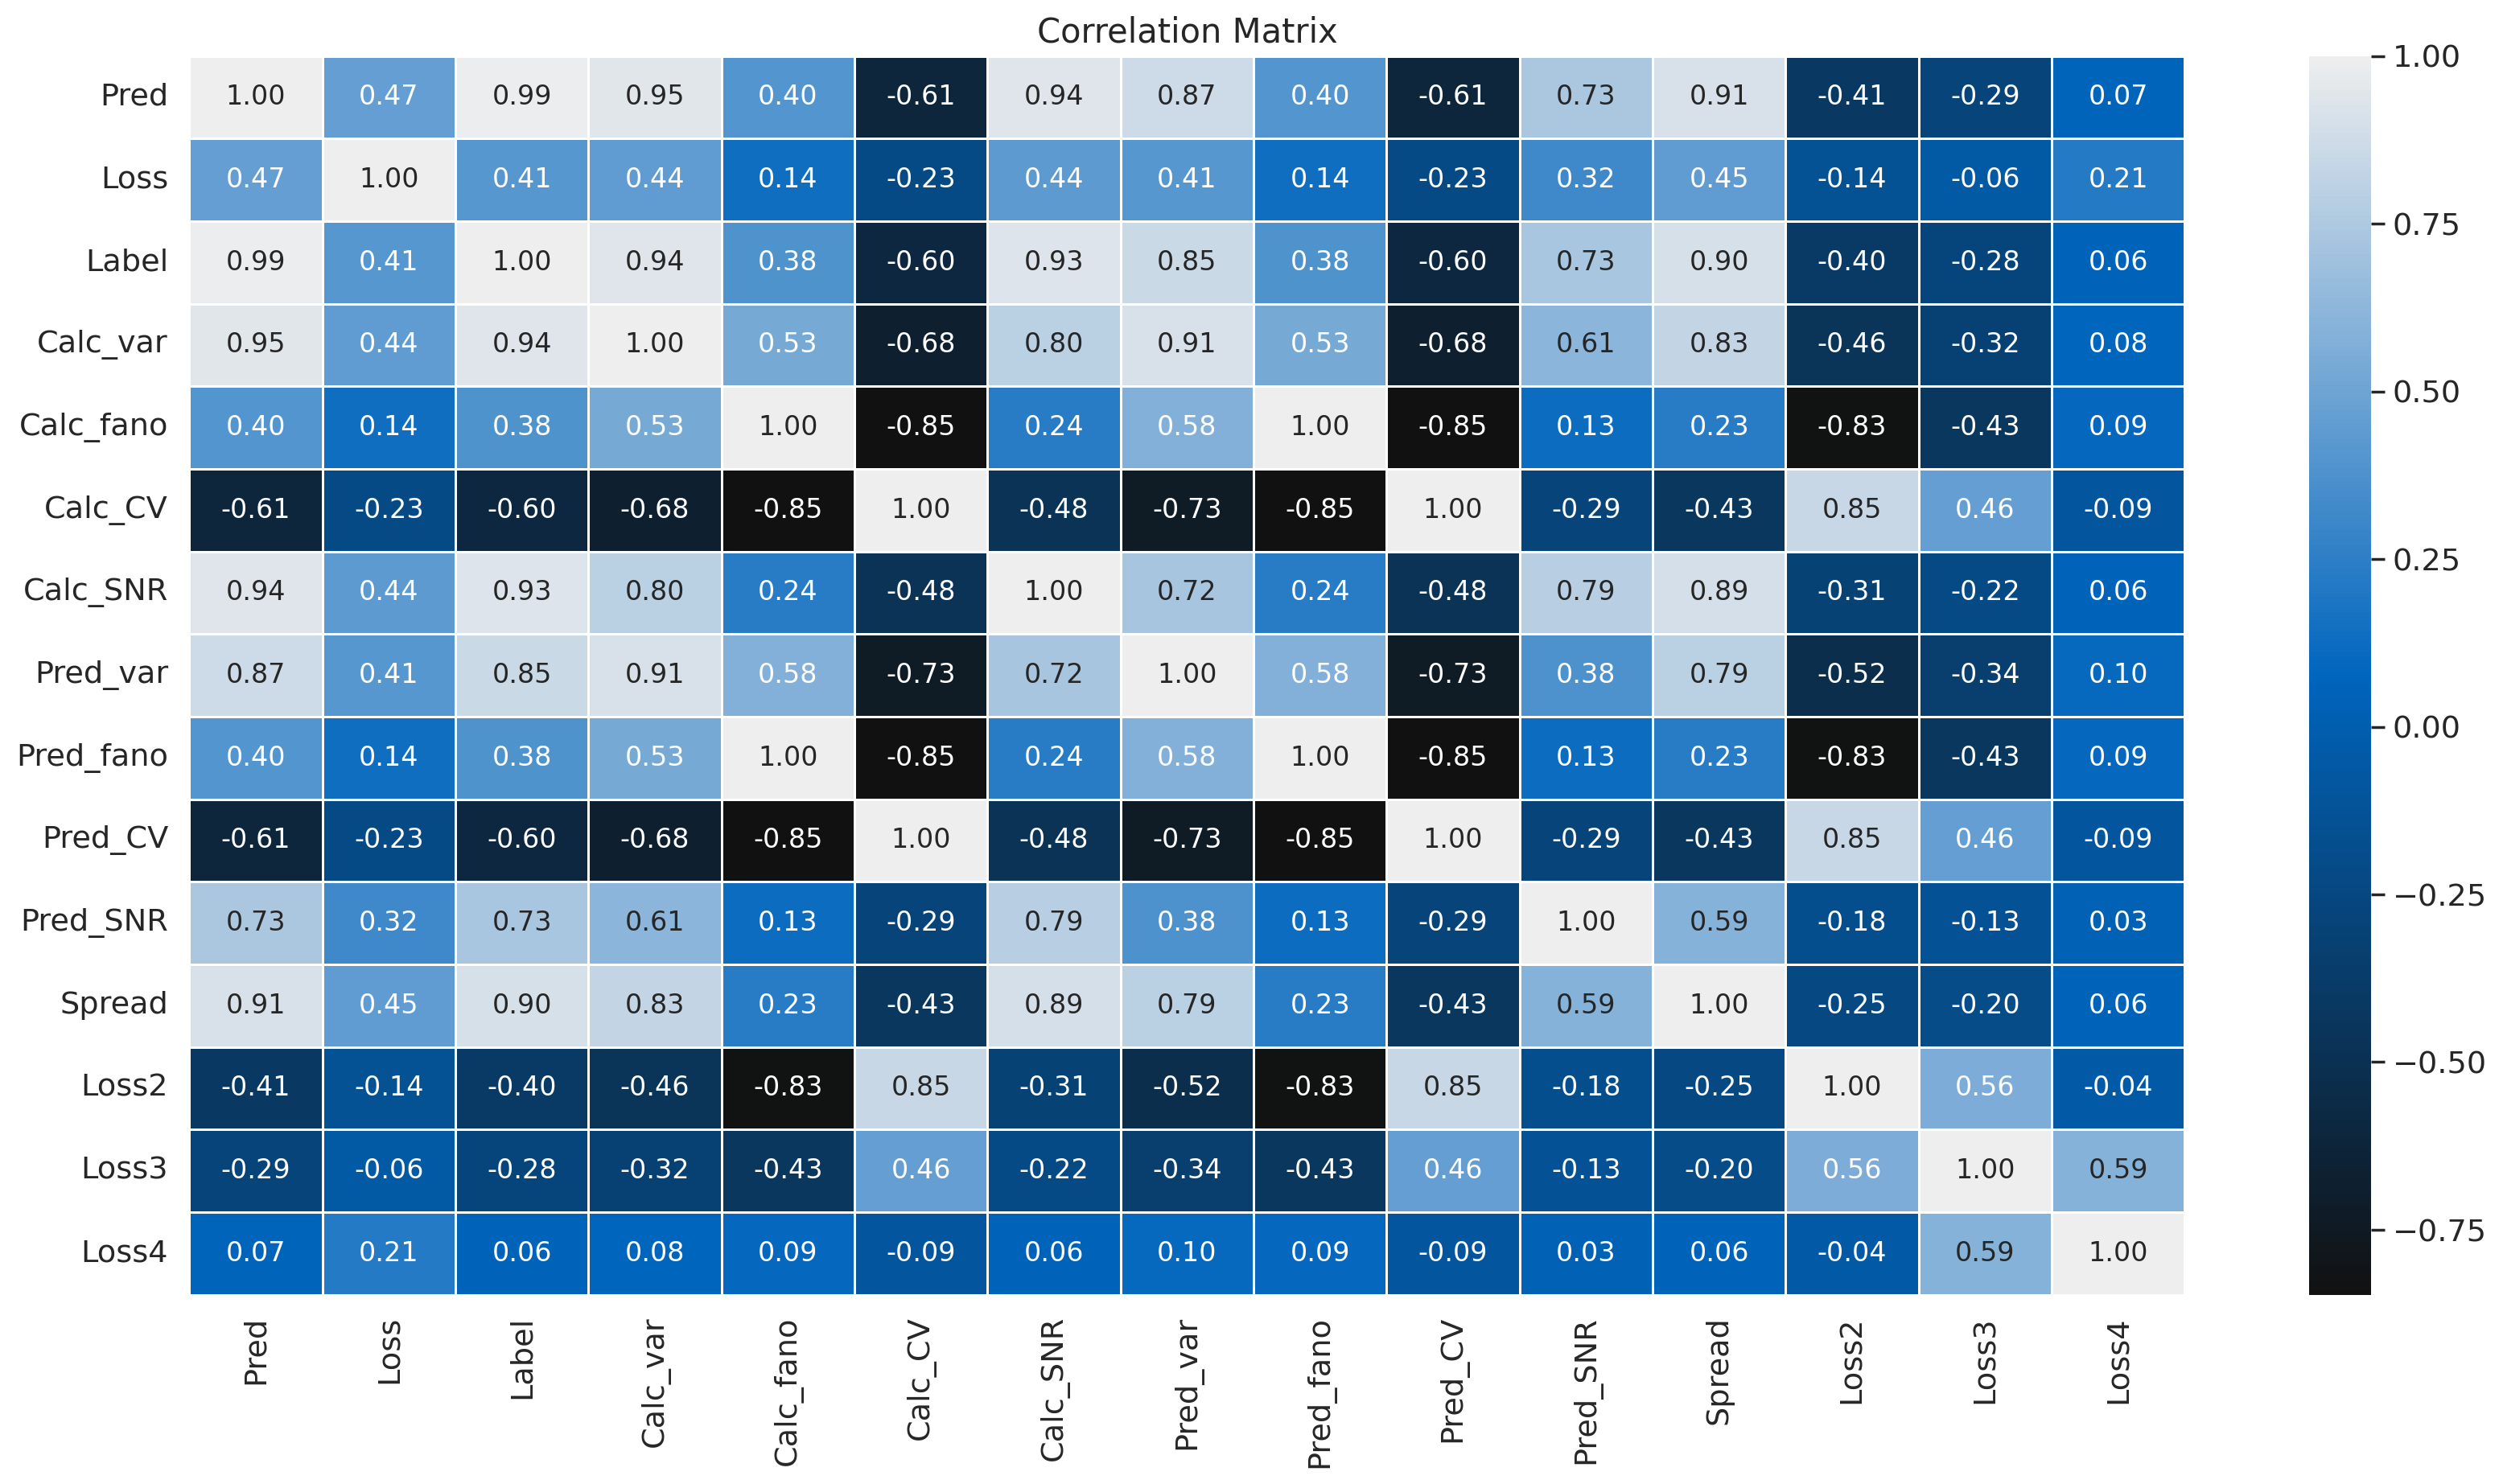

In [24]:
plt.figure(figsize=(20, 10))
# Generate a heatmap
sns.set(font_scale=1.25)

color1 = '#111111'  # Black
color2 = '#0065bd'  # Blue
color3 = '#eeeeee'  # White

# Create the colormap
my_colormap = LinearSegmentedColormap.from_list("my_colormap", [color1, color2, color3])

hm = sns.heatmap(corr_matrix, 
                 cbar=True, 
                 annot=True, 
                 fmt='.2f', 
                 annot_kws={'size': 12}, 
                 yticklabels=corr_matrix.columns, 
                 xticklabels=corr_matrix.columns, 
                 cmap=my_colormap,   # or any other colormap you prefer
                 linewidths=0.5)

plt.title('Correlation Matrix')
#plt.savefig('/home/sam/Desktop/Master_Thesis/UncertaintyCorrelationMatrix.png', format='png', dpi=200)
plt.show()

In [25]:
loss_plot = label
#y_axis = 'loss' / 'label' / 'pred'
y_axis = 'label'

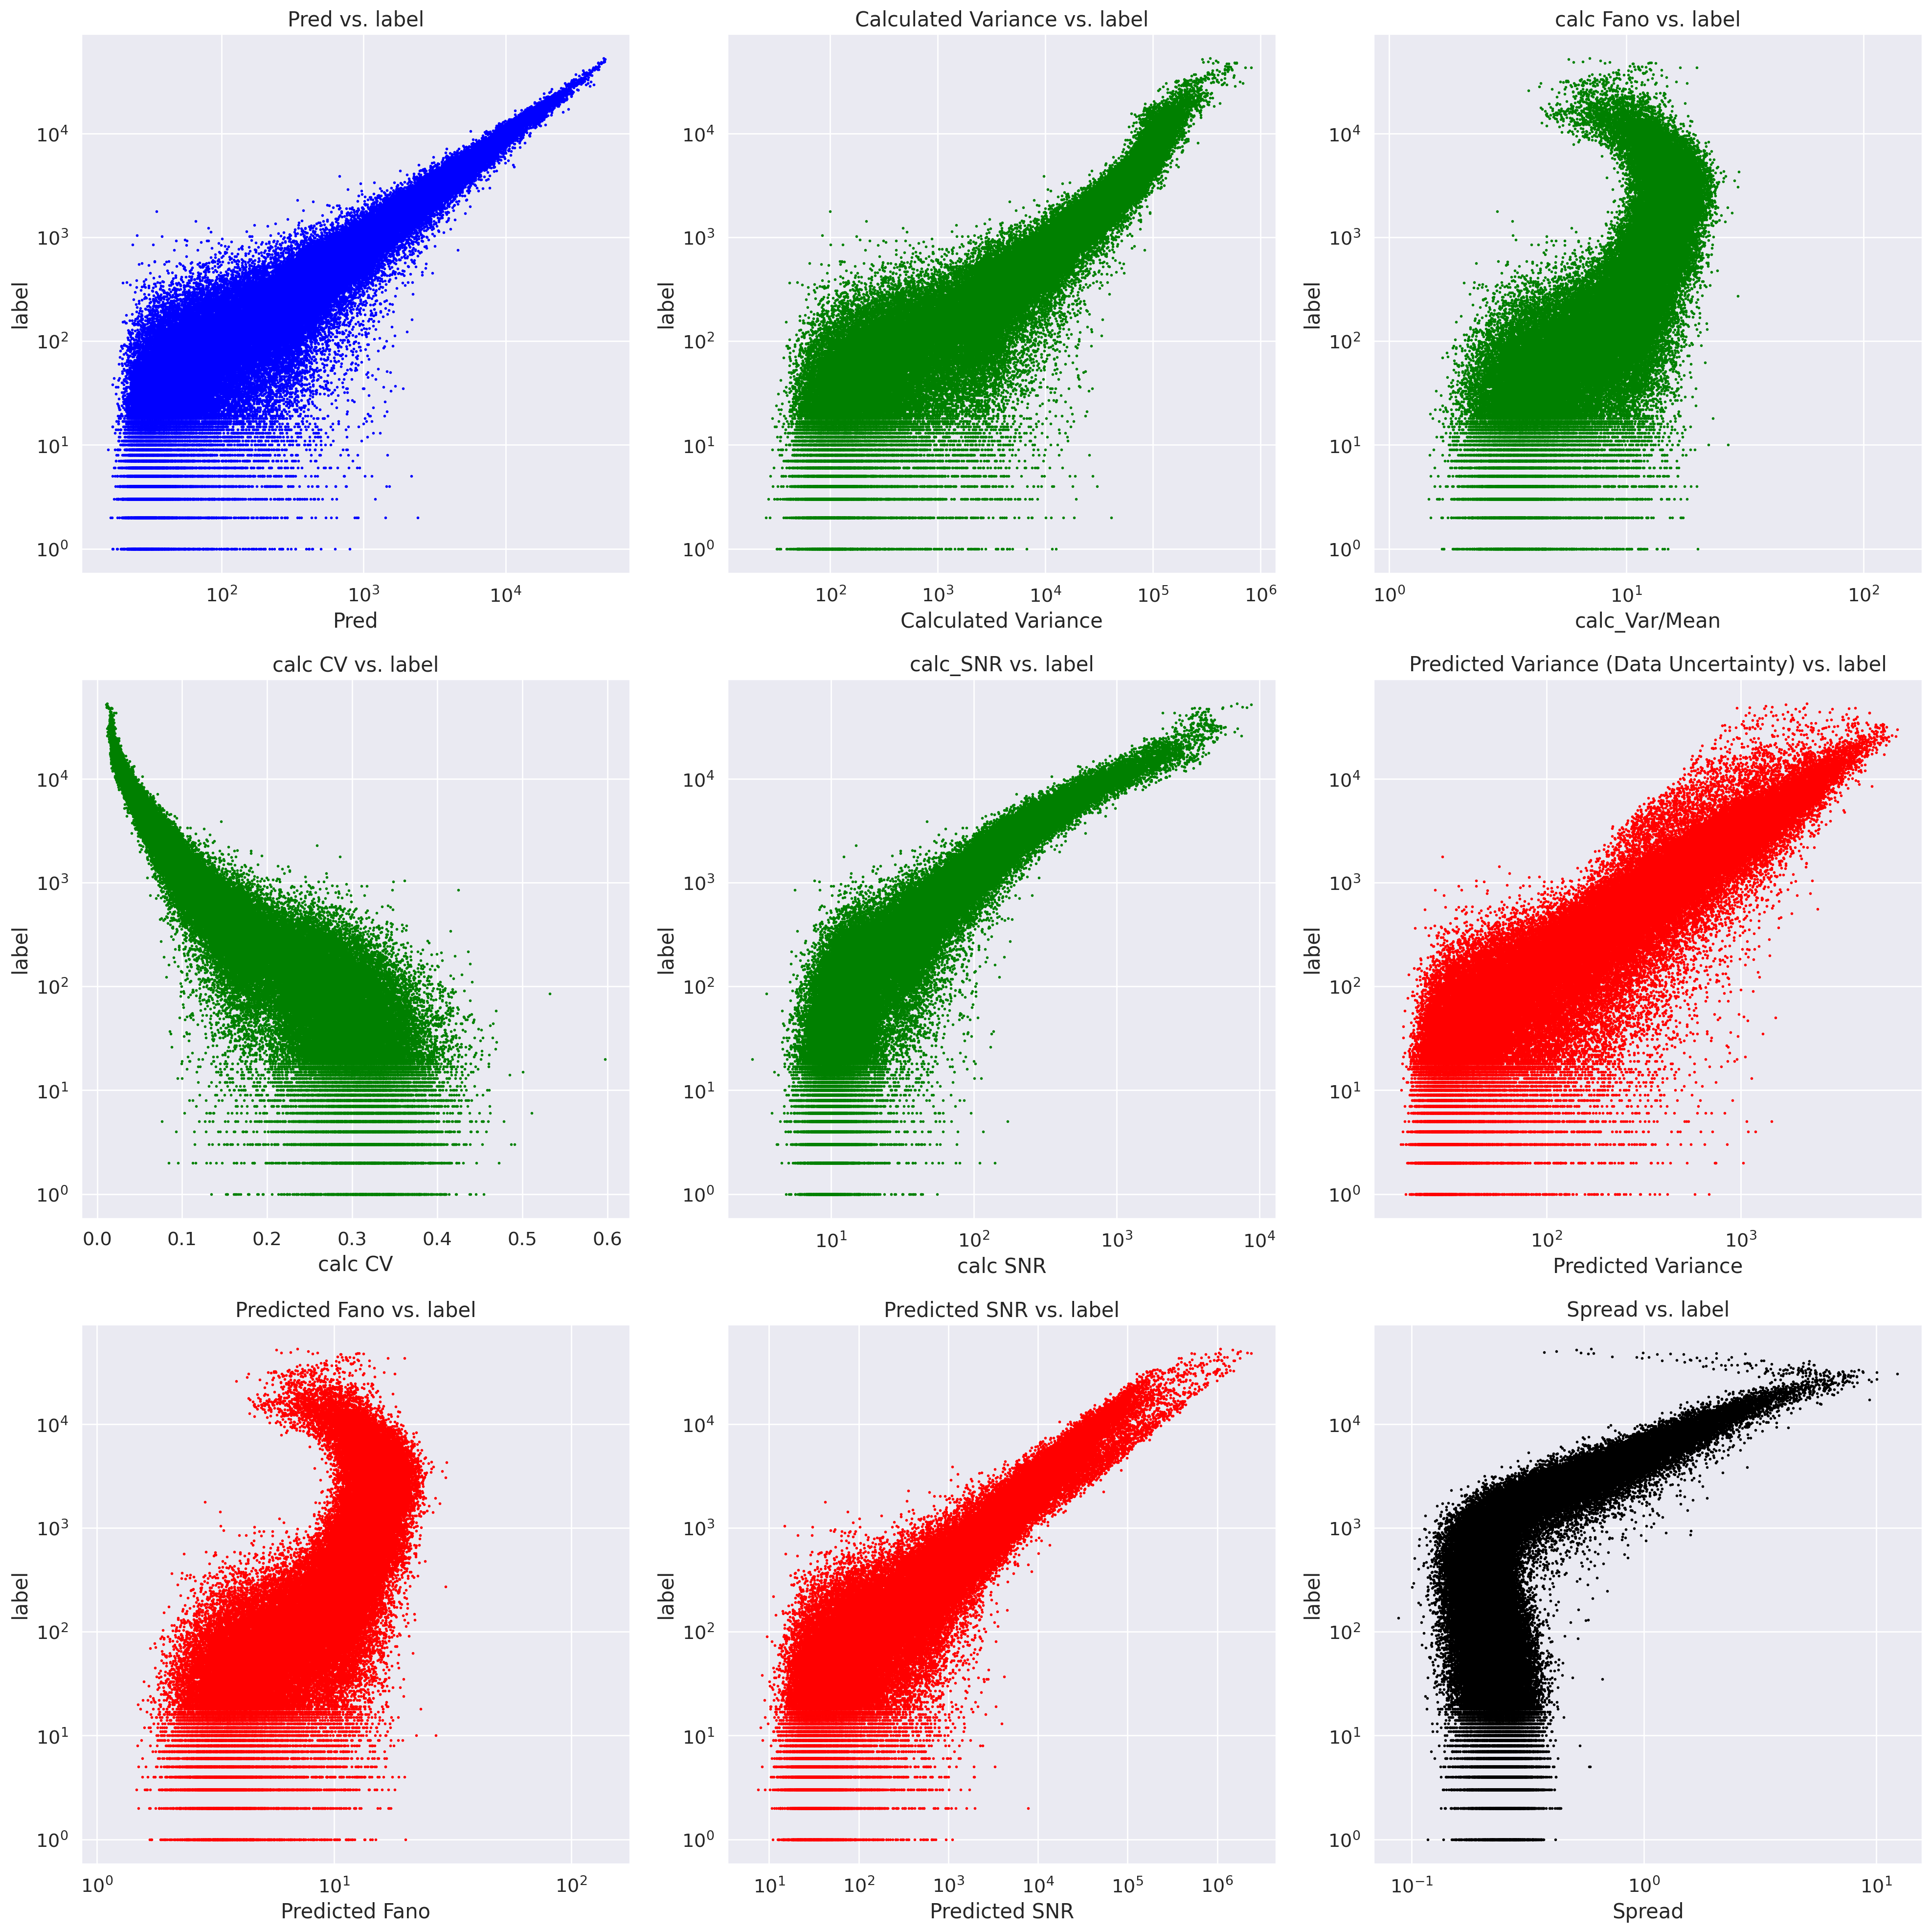

In [26]:
s = 1

# Plot for mean vs. loss
plt.figure(figsize=(20, 20))
ax1 = plt.subplot(3, 3, 1)  # 1 row, 2 columns, 1st plot
ax1.scatter(pred, loss_plot, color='blue', s=s)
ax1.set_title(f"Pred vs. {y_axis}")
ax1.set_xlabel("Pred")
ax1.set_ylabel(y_axis)
ax1.set_xscale('log')
ax1.set_yscale('log')

# Plot for var vs. loss
ax2 = plt.subplot(3, 3, 2)  # 1 row, 2 columns, 2nd plot
ax2.scatter(calc_var, loss_plot, color='green', s=s)
ax2.set_title(f"Calculated Variance vs. {y_axis}")
ax2.set_xlabel("Calculated Variance")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 3)  # 1 row, 2 columns, 2nd plot
ax2.scatter(calc_fano, loss_plot, color='green', s=s)
ax2.set_title(f"calc Fano vs. {y_axis}")
ax2.set_xlabel("calc_Var/Mean")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 4)  # 1 row, 2 columns, 2nd plot
ax2.scatter(calc_CV, loss_plot, color='green', s=s)
ax2.set_title(f"calc CV vs. {y_axis}")
ax2.set_xlabel("calc CV")
ax2.set_ylabel(y_axis)
#ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 5)  # 1 row, 2 columns, 2nd plot
ax2.scatter(calc_SNR, loss_plot, color='green', s=s)
ax2.set_title(f"calc_SNR vs. {y_axis}")
ax2.set_xlabel("calc SNR")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 6)  # 1 row, 2 columns, 2nd plot
ax2.scatter(pred_var, loss_plot, color='red', s=s)
ax2.set_title(f"Predicted Variance (Data Uncertainty) vs. {y_axis}")
ax2.set_xlabel("Predicted Variance")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 7)  # 1 row, 2 columns, 2nd plot
ax2.scatter(pred_fano, loss_plot, color='red', s=s)
ax2.set_title(f"Predicted Fano vs. {y_axis}")
ax2.set_xlabel("Predicted Fano")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 8)  # 1 row, 2 columns, 2nd plot
ax2.scatter(pred_SNR, loss_plot, color='red', s=s)
ax2.set_title(f"Predicted SNR vs. {y_axis}")
ax2.set_xlabel("Predicted SNR")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2 = plt.subplot(3, 3, 9)  # 1 row, 2 columns, 2nd plot
ax2.scatter(spread, loss_plot, color='black', s=s)
ax2.set_title(f"Spread vs. {y_axis}")
ax2.set_xlabel("Spread")
ax2.set_ylabel(y_axis)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
#plt.savefig('/home/sam/Desktop/Master_Thesis/UncertaintiesVsLoss.png', format='png', dpi=200)

In [27]:
from scipy.optimize import curve_fit
# Define the power-law function
def power_law(x, a, b):
    return a * x**(b)

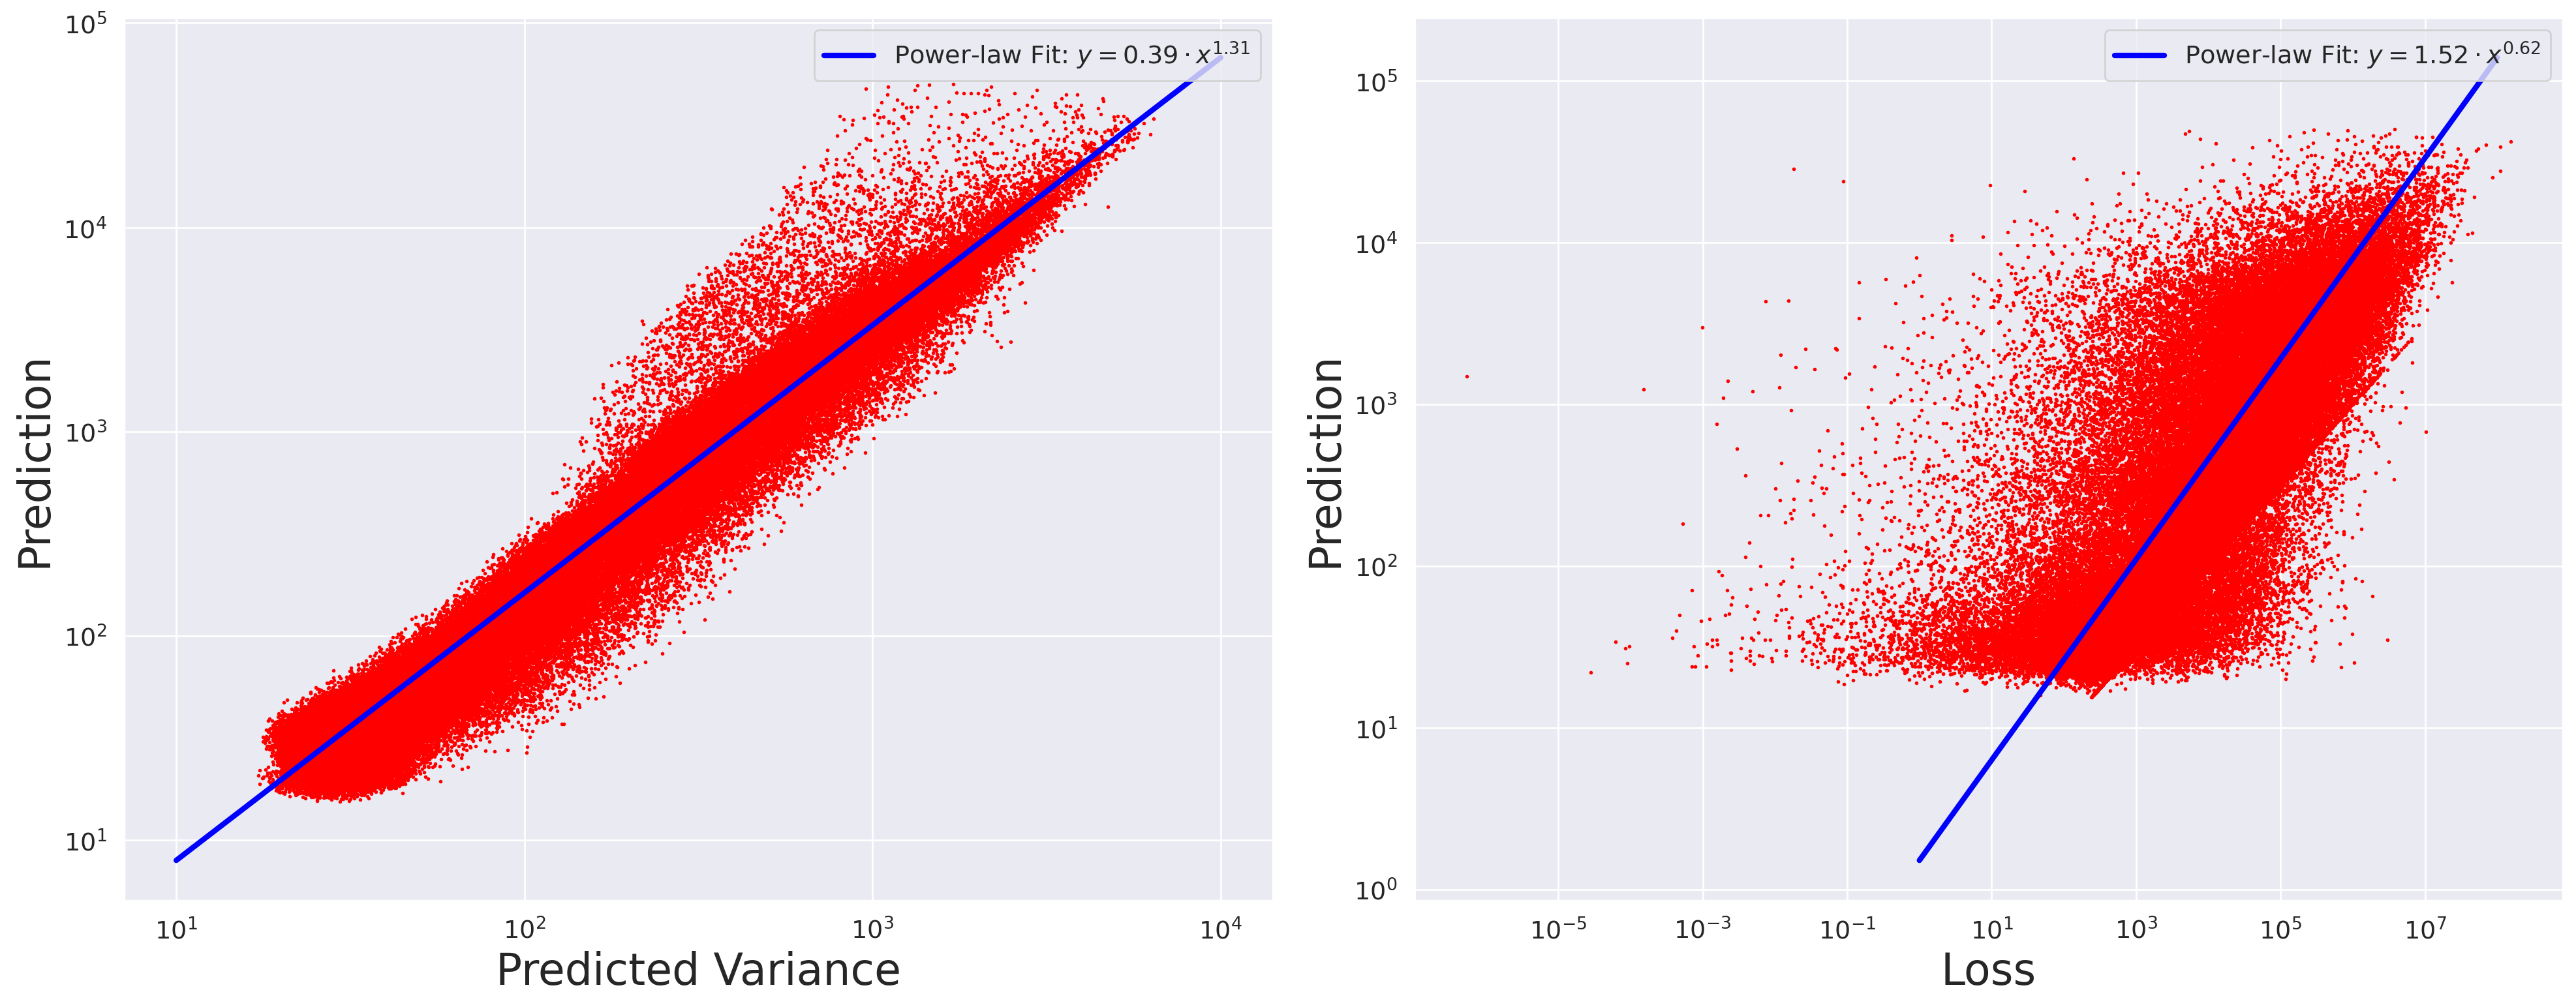

In [28]:
plt.figure(figsize=(20, 8))

c = 100
w = 10

ax2 = plt.subplot(1, 2, 1)
ax2.scatter(pred_var, pred, color='red', s=s)
#ax2.scatter(pred_var[(pred < c-w) | (pred > c+w)], pred[(pred < c-w) | (pred > c+w)], color='grey', s=s)
#ax2.scatter(pred_var[(pred >= c-w) & (pred <= c+w)], pred[(pred >= c-w) & (pred <= c+w)], color='red', s=s)

#x = np.linspace(17, 6000, num=1000)
#coef = np.polyfit(pred_var, pred, 8)
#fit_line = np.polyval(coef, x)
#ax2.plot(x, fit_line, color='blue', linewidth=3, label='implicit Boundary')
#ax2.legend(loc='upper right')

x = np.logspace(1, 4, num=1000)
params, covariance = curve_fit(power_law, pred_var, pred)
a, b = params
a = 0.39
b = 1.31
fit_line = power_law(x, a, b)
ax2.plot(x, fit_line, label=f'Power-law Fit: $y = {a:.2f} \cdot x^{{{b:.2f}}}$', color='blue', linewidth=3)
ax2.legend(loc='upper right')

ax2.set_xlabel("Predicted Variance", fontsize=24)
ax2.set_ylabel('Prediction', fontsize=24)
ax2.set_xscale('log')
ax2.set_yscale('log')


ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
ax2.scatter(loss, pred, color='red', s=s)
#ax2.scatter(loss[(pred < c-w) | (pred > c+w)], pred[(pred < c-w) | (pred > c+w)], color='grey', s=s)
#ax2.scatter(loss[(pred >= c-w) & (pred <= c+w)], pred[(pred >= c-w) & (pred <= c+w)], color='red', s=s)

#x = np.linspace(0, 10_000_000, num=1000)
#coef = np.polyfit(loss, pred, 1)
#fit_line = np.polyval(coef, x)
#ax2.plot(x, fit_line, color='blue', linewidth=3, label='implicit Boundary')
#ax2.legend(loc='upper right')

x = np.logspace(0, 8, num=1000)
params, covariance = curve_fit(power_law, loss, pred)
a, b = params
a = 1.52
b = 0.62
fit_line = power_law(x, a, b)
ax2.plot(x, fit_line, label=f'Power-law Fit: $y = {a:.2f} \cdot x^{{{b:.2f}}}$', color='blue', linewidth=3)
ax2.legend(loc='upper right')

ax2.set_xlabel("Loss", fontsize=24)
ax2.set_ylabel('Prediction', fontsize=24)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
#plt.savefig('/home/sam/Desktop/Master_Thesis/ScatterVarianceLossPowerlawLogMod.png', format='png', dpi=200)

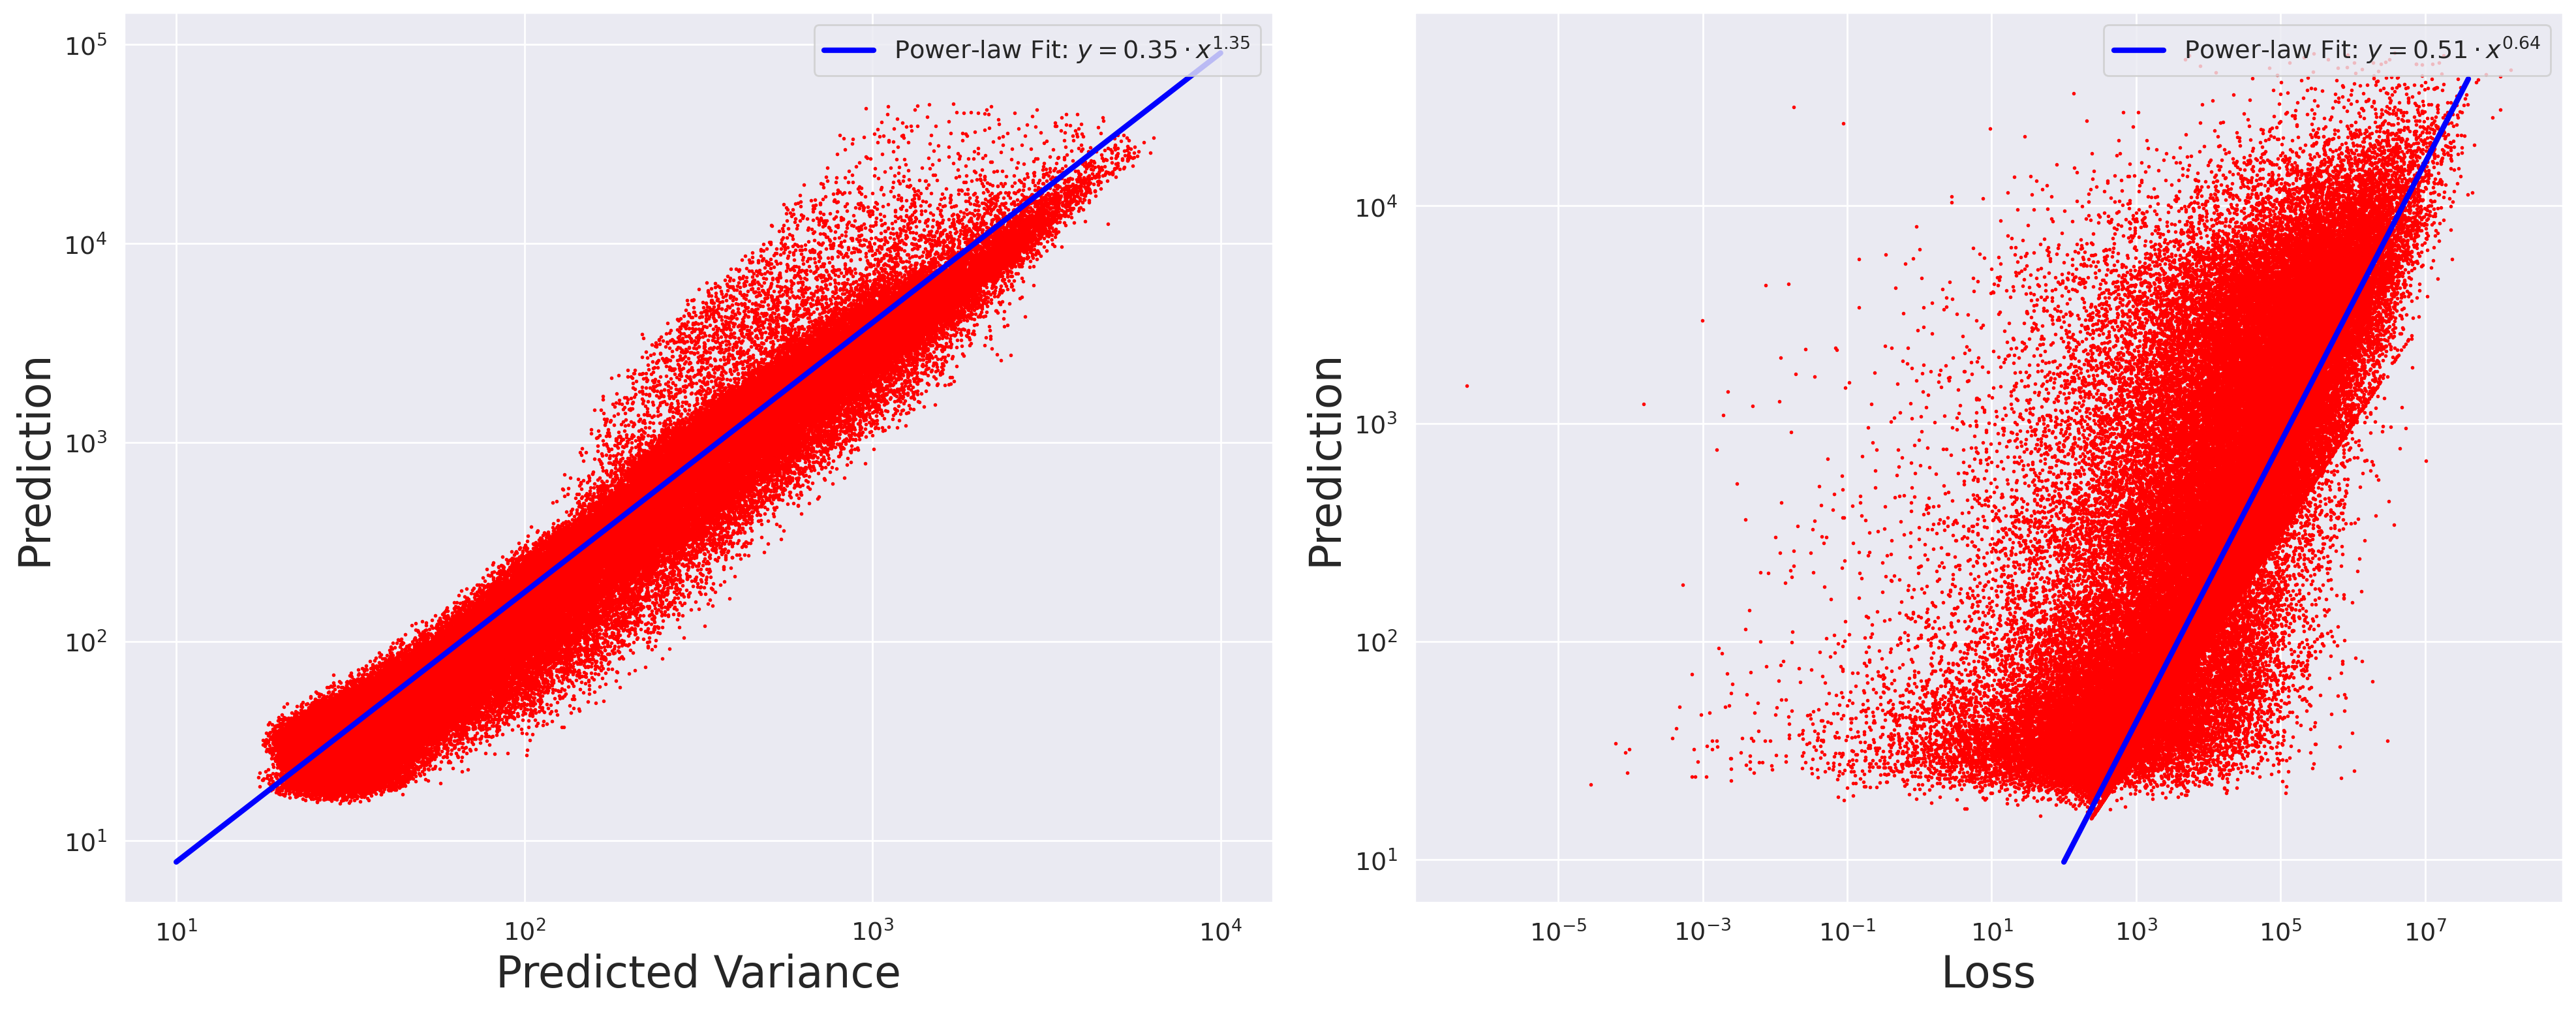

In [34]:
# QUANTILE REGRESSION
plt.figure(figsize=(20, 8))

ax2 = plt.subplot(1, 2, 1)
ax2.scatter(pred_var, pred, color='red', s=s)

# Add a constant to the predictor variable for the intercept term
pred_var_log = sm.add_constant(np.log10(pred_var))
pred_log = np.log10(pred)
# Fit a quantile regression model with a quantile value of 0.5 (median)
model = sm.QuantReg(pred_log, pred_var_log)
result = model.fit(q=0.7)
# Get the fitted parameters
intercept, slope = result.params
# Convert parameters back to original space
a = 10**intercept
b = slope
# Generate values for the fitted power-law curve
x = np.logspace(1, 4, num=1000)
fit_line = (power_law(x, a, b))
ax2.plot(x, fit_line, label=f'Power-law Fit: $y = {a:.2f} \cdot x^{{{b:.2f}}}$', color='blue', linewidth=3)
ax2.legend(loc='upper right')

ax2.set_xlabel("Predicted Variance", fontsize=24)
ax2.set_ylabel('Prediction', fontsize=24)
ax2.set_xscale('log')
ax2.set_yscale('log')

################################

ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
ax2.scatter(loss, pred, color='red', s=s)

# Add a constant to the predictor variable for the intercept term
loss_log = sm.add_constant(np.log10(loss))
pred_log = np.log10(pred)
# Fit a quantile regression model with a quantile value of 0.5 (median)
model = sm.QuantReg(pred_log, loss_log)
result = model.fit(q=0.5)
# Get the fitted parameters
intercept, slope = result.params
# Convert parameters back to original space
a = 10**intercept
b = slope
# Generate values for the fitted power-law curve
x = np.logspace(2, 7.6, num=1000)
fit_line = (power_law(x, a, b))
ax2.plot(x, fit_line, label=f'Power-law Fit: $y = {a:.2f} \cdot x^{{{b:.2f}}}$', color='blue', linewidth=3)
ax2.legend(loc='upper right')

ax2.set_xlabel("Loss", fontsize=24)
ax2.set_ylabel('Prediction', fontsize=24)
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
#plt.savefig('/home/sam/Desktop/Master_Thesis/UncertaintyFitPowerlawLog.png', format='png', dpi=200)

In [28]:
plt.figure(figsize=(10, 7))
plt.scatter(variance, loss_plot, color='blue', alpha=0.4, s=s)
#plt.title(f"CV vs. {y_axis}")
plt.xlabel("Calculated Variance", fontsize=24)
plt.ylabel(y_axis, fontsize=24)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('/home/sam/Desktop/Master_Thesis/ScatterCalculatedVariance.png', format='png', dpi=200)


NameError: name 'variance' is not defined

<Figure size 1000x700 with 0 Axes>